In [84]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xg

from sklearn import preprocessing
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer,mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
        
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import patsy
import pickle

from xgboost import plot_tree
import graphviz


### Wczytaj dane - w naszym przypadku dane o ślimakach

In [38]:
df = pd.read_csv('dane_slimak.csv', encoding = 'utf-8', delim_whitespace=True)

**Zawartoś bazy**

In [39]:
df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
Sex               4177 non-null object
Length            4177 non-null float64
Diameter          4177 non-null float64
Height            4177 non-null float64
Whole weight      4177 non-null float64
Shucked weight    4177 non-null float64
Viscera weight    4177 non-null float64
Shell weight      4177 non-null float64
Rings             4177 non-null int64
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [41]:
df.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


**Zamień wartości na wartości liczbowe. w naszym wypadku jest to tylko 1 kolumna <płeć>**

In [26]:
df['Sex'].replace({'I': 2, 'F': 1, 'M': 0},inplace = True)

In [8]:
df.info()
df.keys()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
Sex               4177 non-null int64
Length            4177 non-null float64
Diameter          4177 non-null float64
Height            4177 non-null float64
Whole weight      4177 non-null float64
Shucked weight    4177 non-null float64
Viscera weight    4177 non-null float64
Shell weight      4177 non-null float64
Rings             4177 non-null int64
dtypes: float64(7), int64(2)
memory usage: 293.8 KB


Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
       'Viscera weight', 'Shell weight', 'Rings'],
      dtype='object')

### Macierz korelacji

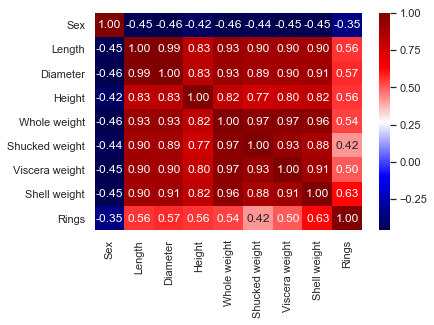

In [9]:
sns.set()
sns.heatmap(df.corr(), cmap = 'seismic', annot=True, fmt=".2f")

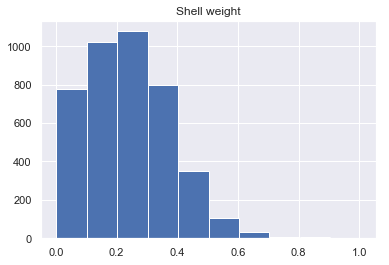

In [10]:
plt.title('Shell weight')
plt.hist(df['Shell weight'])
plt.show()

## Normalizacja

In [11]:
df.keys()

Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
       'Viscera weight', 'Shell weight', 'Rings'],
      dtype='object')

In [4]:
##--------- normalizacja z outleiersami --------
norm_scale = preprocessing.StandardScaler().fit(df[['Sex', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
       'Viscera weight', 'Shell weight']])
df_norm = norm_scale.transform(df[['Sex', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
       'Viscera weight', 'Shell weight']])

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


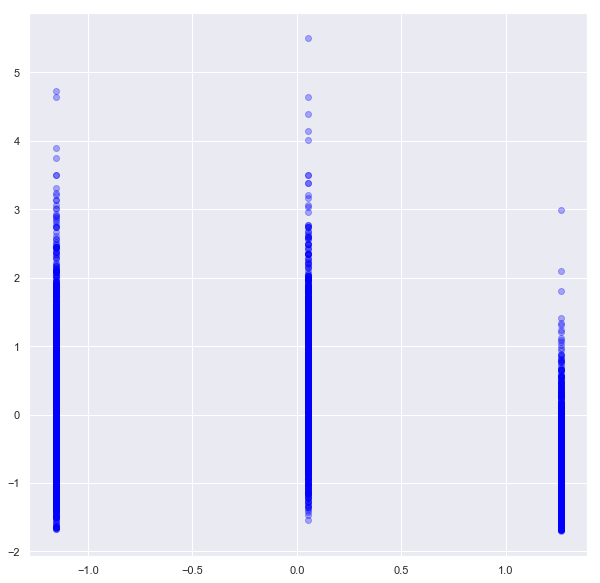

In [13]:
plt.figure(figsize=(10,10))
plt.scatter(df_norm[:,0], df_norm[:,6], color='blue', alpha=0.3)

In [14]:
##----------- usuwanie outlieres --------
quarties = np.array(df[[['Sex', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
       'Viscera weight', 'Shell weight']]].quantile([0.25,0.75]))
down = float(quarties[0]  - 1.5 * (quarties[1]-quarties[0]) )
up = float(quarties[1]  + 1.5 * (quarties[1]-quarties[0]) )

df_ro = df.loc[(df[['Sex', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
       'Viscera weight', 'Shell weight']]> down) & (df[['Sex', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
       'Viscera weight', 'Shell weight']] < up)]

KeyError: "None of [Index([('Sex', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight')], dtype='object')] are in the [columns]"

In [ ]:
norm_scale = preprocessing.StandardScaler().fit(df_ro[['Population', 'HouseAge']])
df_norm_ro = norm_scale.transform(df_ro[['Population', 'HouseAge']])

plt.figure(figsize=(10,10))
plt.scatter(df_norm_ro[:,0], df_norm_ro[:,1], color='blue', alpha=0.3)

In [ ]:
pop_sd = np.std(df_ro['Population'])
pop_m = np.mean(df_ro['Population'])
pop_z = (df['Population'] - pop_m)/pop_sd

plt.figure(figsize=(10,10))
plt.scatter(pop_z, df_norm[:,1], color='blue', alpha=0.3)

### Prepare features and target

In [27]:
columns_drop = ['Rings','Length']
X = df.drop(columns=columns_drop, axis = 1)
y = df['Rings']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 100)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state = 100)

## Modele 

### Linear regression


In [17]:
clf_linear = LinearRegression()
clf_linear.fit(X_train, y_train)
accuracy_linear = clf_linear.score(X_val, y_val)
y_pred_linear = clf_linear.predict(X_val)
mae_linear = mean_absolute_error(y_val, y_pred_linear)

### SVR

In [ ]:
clf_SVR = SVR(gamma='scale', C=1.0, epsilon=0.2)
clf_SVR.fit(X_train, y_train)
y_pred_SVR = clf_SVR.predict(X_val)
accuracy_SVR = clf_SVR.score( y_val,y_pred_SVR,)
mae_SVR = mean_absolute_error(y_val, y_pred_SVR)

### Random Forest Regressor

In [ ]:
clf_RFC = RandomForestRegressor(n_estimators=10, max_depth=10, min_samples_leaf=2, random_state=100)
clf_RFC.fit(X_train, y_train)
y_pred_RFC = clf_RFC.predict(X_val)
#accuracy_RFC = clf_RFC.score(y_val,y_pred_RFC)
mae_RFC = mean_absolute_error(y_val, y_pred_RFC)


### XGBoost

In [54]:
clf_XGB = xg.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
clf_XGB.fit(X_train, y_train)
y_pred_XGB = clf_XGB.predict(X_val)
#accuracy_XGB = clf_XGB.score(y_val,y_pred_XGB)
mae_XGB = mean_absolute_error(y_val, y_pred_XGB)
rmse_XGB = np.sqrt(mean_squared_error(y_val, y_pred_XGB))
print("RMSE: {} MAE: {}".format(rmse_XGB,mae_XGB))

RMSE: 4.2264576477787035 MAE: 3.3803333976167314


In [86]:
mds = np.arange(3,6)
lrs = np.arange(0.05,0.3,0.10)
n_splits = 20
params = list(itertools.product(mds,lrs))
n= len(params)

data = {"max depth" : [], "learning_rate" :[],"mean_squared_error":[]}

for i, (md,lr) in enumerate(params):
    model = xg.XGBRegressor(max_depth=md,learning_rate=lr)
    cv = KFold(n_splits=n_splits)
    scorer = make_scorer(mean_squared_error)
    cv_result = cross_val_score(model,X_train,y_train,cv=cv,scoring=scorer)

    data["mean_squared_error"].extend(cv_result)
    data["max depth"].extend([md]*n_splits)
    data["learning_rate"].extend([lr]*n_splits)

    print("{}/{}".format(i,n))

df = pd.DataFrame(data=data)
min_error = df["mean_squared_error"].min()
max_error = df["mean_squared_error"].max()

out = {
    "min_error":min_error,
    "max_error" : max_error,
    "df":df
}

0/9
1/9
2/9
3/9
4/9
5/9
6/9
7/9
8/9


In [87]:
print(out)

{'min_error': 3.4318765430468305, 'max_error': 7.4291341732117555, 'df':      max depth  learning_rate  mean_squared_error
0            3           0.05            6.210887
1            3           0.05            4.123911
2            3           0.05            6.028601
3            3           0.05            4.331790
4            3           0.05            4.109387
5            3           0.05            5.064005
6            3           0.05            5.471036
7            3           0.05            4.787739
8            3           0.05            4.447524
9            3           0.05            5.603879
10           3           0.05            4.190109
11           3           0.05            5.459442
12           3           0.05            5.535572
13           3           0.05            5.344358
14           3           0.05            5.169577
15           3           0.05            3.431877
16           3           0.05            3.714566
17           3           0.

Different way of selecting hyperparameters

In [88]:
data_dmatrix = xg.DMatrix(data=X_train,label=y_train)

params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.2,
                'max_depth': 10, 'alpha': 10}

cv_results = xg.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=90,early_stopping_rounds=10,metrics="mse", as_pandas=True, seed=123)

cv_results.head()
cv_results.tail()

XGBoostError: b'[21:59:16] src/metric/metric.cc:21: Unknown metric function mse\n\nStack trace returned 7 entries:\n[bt] (0) 0   libxgboost.dylib                    0x0000001a19712b01 dmlc::StackTrace() + 305\n[bt] (1) 1   libxgboost.dylib                    0x0000001a1971288f dmlc::LogMessageFatal::~LogMessageFatal() + 47\n[bt] (2) 2   libxgboost.dylib                    0x0000001a1978bc55 xgboost::Metric::Create(std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > const&) + 885\n[bt] (3) 3   libxgboost.dylib                    0x0000001a1970cd5e xgboost::LearnerImpl::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > >, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > > > > const&) + 606\n[bt] (4) 4   libxgboost.dylib                    0x0000001a1972ba83 XGBoosterUpdateOneIter + 131\n[bt] (5) 5   libffi.6.dylib                      0x000000010713c884 ffi_call_unix64 + 76\n[bt] (6) 6   ???                                 0x00007fff5a9dc650 0x0 + 140734713677392\n\n'

In [81]:
print((cv_results["test-rmse-mean"]).tail(1))

42    2.241826
Name: test-rmse-mean, dtype: float64


### Feature importance

number of times each feature is split on across all boosting rounds (trees) in the model

[21:42:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[21:42:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[21:42:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[21:42:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[21:42:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[21:42:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[21:42:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[21:42:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[21:42:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_

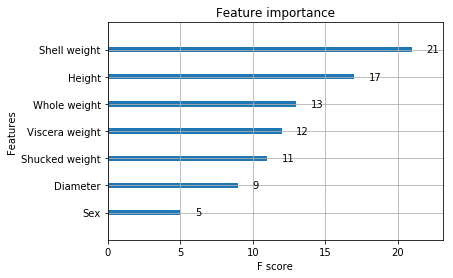

In [64]:
xg_reg = xg.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

xg.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [ ]:
#DecisionTreeRegressor
clf_DTR = DecisionTreeRegressor()
clf_DTR.fit(X_train, y_train)
y_pred_DTR = clf_DTR.predict(X_val)
#accuracy_DTR = clf_DTR.score(y_val,y_pred_DTR)
mae_DTR = mean_absolute_error(y_val, y_pred_DTR)

In [10]:
# print('MAE Linear regression:', mae_linear)
# print('MAE SVR:', mae_SVR)
# print('MAE RFC:', mae_RFC)
print('MAE XBG:', mae_XGB)
# print('MAE DTR:', mae_DTR)

MAE XBG: 1.551615572356163
